# Cross-Conditional Mapping in Multiple Conditions

- In this tutorial we aim to show how Patches (or other models) can be applied generally for cross-condition prediction using the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- We will also show how the model decouples latents with respect to attribute combinations.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.

- Please refer to the interpretable tutorial for quantitative assessment of biological implications.

In [1]:
# Minimal imports
from ladder.data import get_data
from ladder.scripts import CrossConditionWorkflow # Our workflow object to run the cross-conditional model
import umap, torch, pyro # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from umap import UMAP

# For data loading
import anndata as ad
import scanpy as sc



# Plotting function we will need to call
def plot_fig(df, hue):
    # Custom color palette
    klee_palette = [
        "#8B1E3F",  # Deep Burgundy
        "#3B5998",  # Rich Blue
        "#F4A261",  # Warm Orange
        "#E9C46A",  # Soft Yellow
        "#2A9D8F",  # Muted Green
        "#E76F51",  # Burnt Sienna
    ]

    legend_map = {
        "broad_type" : "Cell Types",
        "time" : "Timepoints",
        "age" : "Age",
        "factorized" : "Concatenated Factors",
    }

    palette_map = {
        "broad_type" : sns.color_palette(klee_palette),
        "time" : sns.color_palette("Set2", 3),
        "age" : sns.color_palette("Set1", 2),
        "factorized" : sns.color_palette("tab10", 6),
    }
    
    palette = palette_map[hue]
    
    
    
    fig = plt.figure(figsize=(15, 11.25))
    
    gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.5)
    
    ax = [
        fig.add_subplot(gs[0, 0]), 
        fig.add_subplot(gs[0, 1]), 
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]), 
    ]
    
    ## Define a new GridSpec for axis to split vertically
    gs_inner_topright = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0, 1])
    
    ## Create subplots for the inner grid
    ax_inner_topright = [
        fig.add_subplot(gs_inner_topright[0]),
        fig.add_subplot(gs_inner_topright[1]), 
        fig.add_subplot(gs_inner_topright[2])
    ]
    
    
    ax[1].axis('off')
    
    
    # Plots
    scatter = sns.scatterplot(df, x="base_1", y="base_2", ax=ax[0], hue=hue, legend=True, palette=palette, alpha=0.6, s=10)
    sns.scatterplot(df, x="z_umap_1", y="z_umap_2", ax=ax[2], hue=hue, legend=False, palette=palette, alpha=0.6, s=10)
    sns.scatterplot(df, x="w_umap_1", y="w_umap_2", ax=ax[3], hue=hue, legend=False, palette=palette, alpha=0.6, s=10)
    
    sns.stripplot(df, y = "z_pc_1", hue=hue, zorder=1, alpha=0.6, ax=ax_inner_topright[0], legend=False, palette=palette)
    ax_inner_topright[0].axvline(zorder=2, color='black', linestyle = 'dashed')
    
    sns.stripplot(df, y = "w_pc_1", hue=hue, zorder=1, alpha=0.6, ax=ax_inner_topright[1], legend=False, palette=palette)
    ax_inner_topright[1].axvline(zorder=2, color='black', linestyle = 'dashed')

    sns.stripplot(df, y = "w_pc_2", hue=hue, zorder=1, alpha=0.6, ax=ax_inner_topright[2], legend=False, palette=palette)
    ax_inner_topright[1].axvline(zorder=2, color='black', linestyle = 'dashed')
    
    
    
    
    # Prettier
    h, l = scatter.get_legend_handles_labels()
    scatter.legend([])
    
    for subax in ax:
        subax.set_xticklabels([])
        subax.set_xticks([])
        subax.set_yticklabels([])
        subax.set_yticks([])
        subax.set_xlabel('')
        subax.set_ylabel('')
    
    for subax in ax_inner_topright:
        subax.set_xticklabels([])
        subax.set_xticks([])
        subax.set_yticklabels([])
        subax.set_yticks([])
        subax.set_xlabel('')
        subax.set_ylabel('')
    
    ax[0].set_title("Base UMAP")
    ax[2].set_title("Common - UMAP")
    ax[3].set_title("Conditional - UMAP")
    
    ax_inner_topright[0].set_title("Common - PC1", fontsize=10)
    ax_inner_topright[1].set_title("Conditional - PC1", fontsize=10)
    ax_inner_topright[2].set_title("Conditional - PC2", fontsize=10)

    
    
    
    fig.legend(h,l, title=legend_map[hue], loc="center")
    
        
    plt.show()



# Formatting The Data

The workflows use [anndata](https://anndata.readthedocs.io/en/latest/) objects as input. Specifically, the data we provide can also be manually downloaded [here](https://drive.google.com/file/d/1quCP3403hOPG5Q8cy1KWZui_a0mJrQ5J/view?usp=drive_link). 

In [2]:
# Download the data object
get_data("Vu") 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57.5M/57.5M [00:00<00:00, 801MB/s]

Object saved at ./data/vu_2022_ay_wh.h5ad


In [3]:
# Load the anndata object
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")
anndata

AnnData object with n_obs × n_vars = 31509 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper', 'time', 'age', 'seq', 'sample', 'percent.mt', 'RNA_snn_res.0.2', 'seurat_clusters', 'harmony_clusters', 'broad_type'

# Initializing the Cross-Condition Workflow
- Models can be run through two workflow interfaces: **CrossConditionWorkflow** and **InterpretableWorkflow** (see the corresponding [tutorial](interpretable_vu_tutorial.ipynb))

- Once initialized, you can train and evaluate the model through the workflow interface. 

In [4]:
# Initialize workflow object
workflow = CrossConditionWorkflow(anndata, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "age"]
workflow.prep_model(factors, batch_key="sample", cell_type_label_key="broad_type", model_type='Patches')

# Train the model
workflow.run_model(max_epochs=300, convergence_threshold=1e-4, convergence_window=15) # Lower the convergence threshold and increase window if you need a more accurate model, for tutorial purposes we will limit to this

Initialized workflow to run cross-condition model.

Condition classes : ['time', 'age']
Number of attributes per class : [3, 2]

Initialized Patches model.
Model arguments: {'reconstruction': 'ZINB', 'batch_correction': True, 'scale_factor': 2.6041666666666666e-06, 'num_labels': 5, 'len_attrs': [3, 2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.01, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 300, with convergence eps 0.0001.
Using device: cuda

Epoch : 0 || Train Loss: 1.05492 // 1.77691 || Test Loss: 0.90729 // 1.76925 || Warmup : False
Epoch : 1 || Train Loss: 0.89783 // 1.76481 || Test Loss: 0.84997 // 1.76305 || Warmup : False
Epoch : 2 || Train Loss: 0.8629 // 1.76364 || Test Loss: 0.80952 // 1.76168 || Warmup : False
Epoch : 3 || Train Loss: 0.81242 // 1.75968 || Test Loss: 0.77236 // 1.7588 || Warmup : False
Epoch : 4 || Train

## Observing the losses

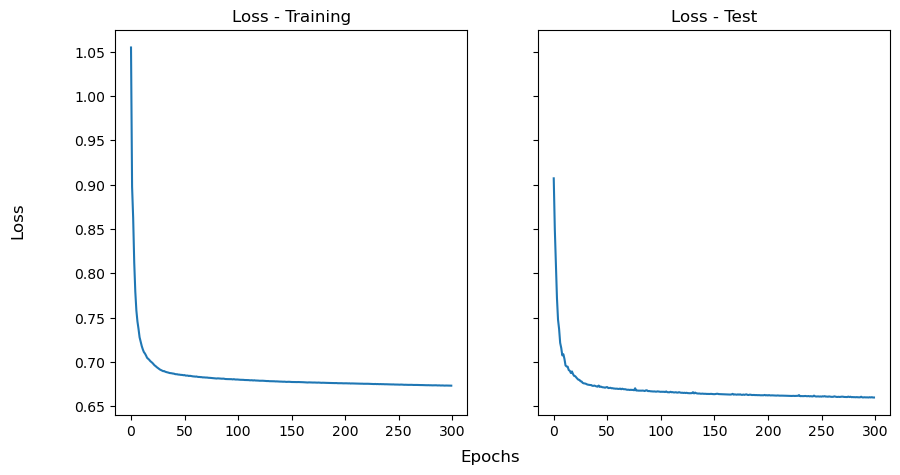

In [5]:
workflow.plot_loss()

## Evaluate reconstruction

In [6]:
# For overall cells
workflow.evaluate_reconstruction()

print("\n")

# For specific cell types
workflow.evaluate_reconstruction(cell_type="Keratinocyte")

Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.93s/it]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.14s/it]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Calculating Chamfer Discrepancy ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.40it/s]


Results
RMSE : 0.2 +- 0.0
Profile Correlation : 0.987 +- 0.0
2-Sliced Wasserstein : 0.264 +- 0.0
Chamfer Discrepancy : 0.387 +- 0.0


Subsetting test to Keratinocyte cells
Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


Calculating Chamfer Discrepancy ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 92.81it/s]

Results
RMSE : 0.84 +- 0.001
Profile Correlation : 0.815 +- 0.0
2-Sliced Wasserstein : 0.319 +- 0.0
Chamfer Discrepancy : 0.438 +- 0.0


## Evaluate Cross-Condition

In [7]:
workflow.levels

{'time_0DPW - age_Aged': (1, 0, 0, 1, 0),
 'time_0DPW - age_Young': (1, 0, 0, 0, 1),
 'time_4DPW - age_Aged': (0, 1, 0, 1, 0),
 'time_4DPW - age_Young': (0, 1, 0, 0, 1),
 'time_7DPW - age_Aged': (0, 0, 1, 1, 0),
 'time_7DPW - age_Young': (0, 0, 1, 0, 1)}

In [8]:
# For overall cells, might be misleading if proportions / cell types across conditions are heterogenous
workflow.evaluate_transfer(source="time_0DPW - age_Young", target="time_0DPW - age_Aged")

print("\n")

# For a specific cell type
workflow.evaluate_transfer(source="time_0DPW - age_Young", target="time_0DPW - age_Aged", cell_type="Keratinocyte")

Evaluating mapping...
Source: time_0DPW - age_Young --> Target: time_0DPW - age_Aged
Calculating RMSE ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Calculating Profile Correlation ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


Calculating 2-Sliced Wasserstein ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.96it/s]


Calculating Chamfer Discrepancy ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.05it/s]


Results
RMSE : 0.324 +- 0.0
Profile Correlation : 0.966 +- 0.0
2-Sliced Wasserstein : 0.252 +- 0.0
Chamfer Discrepancy : 0.423 +- 0.0


Subsetting test to Keratinocyte cells
Evaluating mapping...
Source: time_0DPW - age_Young --> Target: time_0DPW - age_Aged
Calculating RMSE ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]


Calculating Profile Correlation ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.71it/s]


Calculating 2-Sliced Wasserstein ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.36it/s]


Calculating Chamfer Discrepancy ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 150.82it/s]

Results
RMSE : 0.918 +- 0.001
Profile Correlation : 0.804 +- 0.0
2-Sliced Wasserstein : 0.321 +- 0.0
Chamfer Discrepancy : 0.468 +- 0.0


## Obtain latent embeddings and quantify separability of condition effects

In [9]:
workflow.write_embeddings()

print('Time factor separability:')
workflow.evaluate_separability('time')

print('\n\nAge factor separability:')
workflow.evaluate_separability('age')

print('\n\nTime x Age combined factor separability:')
workflow.evaluate_separability() #Explicitly, this calls workflow.evaluate_separability('factorized')!

Written embeddings to object 'anndata.obsm' under workflow.
Time factor separability:
Running for embedding: patches_w_latent
Running for embedding: patches_z_latent
Results

patches_w_latent
kNN Classifier Accuracy : 1.0
K-Means NMI : 1.0
K-Means ARI : 1.0
Average Silhouette Width : 0.796

patches_z_latent
kNN Classifier Accuracy : 0.645
K-Means NMI : 0.001
K-Means ARI : 0.002
Average Silhouette Width : 0.497


Age factor separability:
Running for embedding: patches_w_latent
Running for embedding: patches_z_latent
Results

patches_w_latent
kNN Classifier Accuracy : 1.0
K-Means NMI : 0.337
K-Means ARI : 0.203
Average Silhouette Width : 0.737

patches_z_latent
kNN Classifier Accuracy : 0.7
K-Means NMI : 0.0
K-Means ARI : -0.0
Average Silhouette Width : 0.499


Time x Age combined factor separability:
Running for embedding: patches_w_latent
Running for embedding: patches_z_latent
Results

patches_w_latent
kNN Classifier Accuracy : 1.0
K-Means NMI : 1.0
K-Means ARI : 1.0
Average Silhouett

## Qualitatively observing the separation

- In the plots below, we can see that the conditional latent is separated with respect to condition combinations.

- Specifically, the principal components of the conditional latent are layered with respect to attributes for condition classes.
 

In [10]:
# Data reduction for visualization

## Parameters for UMAP
reducer = umap.UMAP(n_neighbors=40, min_dist=0.1, metric="correlation", verbose=False, random_state=42)

## All data reductions we need for the plots
base_umap = reducer.fit_transform(np.array(workflow.anndata.X.todense()))
z_umap = reducer.fit_transform(workflow.anndata.obsm['patches_z_latent']) ## Z
w_umap = reducer.fit_transform(workflow.anndata.obsm['patches_w_latent']) ## W
w_pca = sc.pp.pca(workflow.anndata.obsm['patches_w_latent'], random_state=42)[:,:2] ## W PCA, grab first 2 PCs
z_pca = sc.pp.pca(workflow.anndata.obsm['patches_z_latent'], random_state=42)[:,:2] ## Z PCA, grab first 2 PCs


## Put it all in a single dataframe for plotting
df = pd.DataFrame(base_umap)
df.index = anndata.obs.index

df.columns = ["base_1", "base_2"]
df["z_umap_1"], df["z_umap_2"] = z_umap[:,0], z_umap[:,1]
df["w_umap_1"], df["w_umap_2"] = w_umap[:,0], w_umap[:,1]
df["z_pc_1"], df["z_pc_2"] = z_pca[:,0], z_pca[:,1]
df["w_pc_1"], df["w_pc_2"] = w_pca[:,0], w_pca[:,1]
df["broad_type"], df["age"], df["time"], df["factorized"] = workflow.anndata.obs["broad_type"], workflow.anndata.obs["age"], workflow.anndata.obs["time"], workflow.anndata.obs["factorized"]

/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/insomnia001/depts/morpheus/users/ob2391/miniforge3/envs/csvae/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Base & Latents per Cell Type



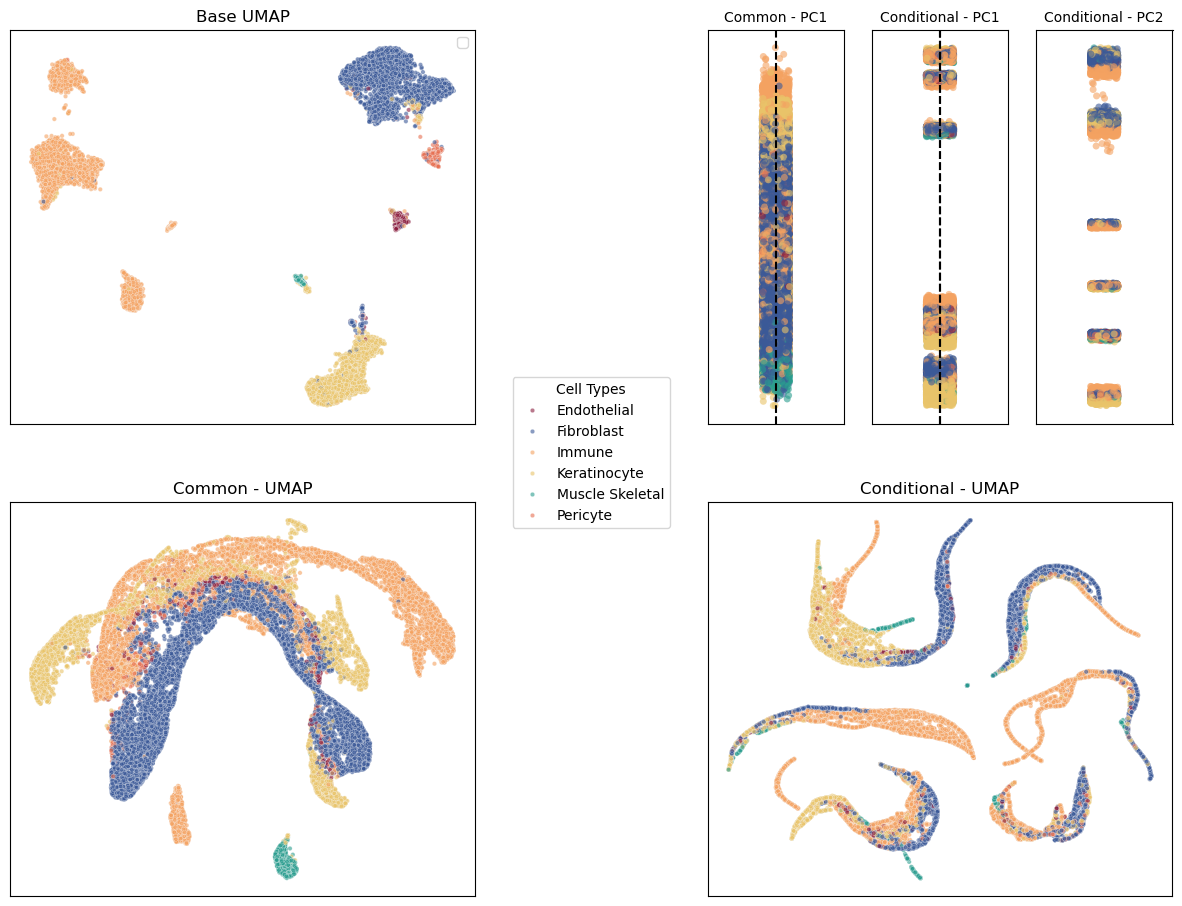

In [11]:
plot_fig(df, hue="broad_type")

## Base & Latents per Condition - Time

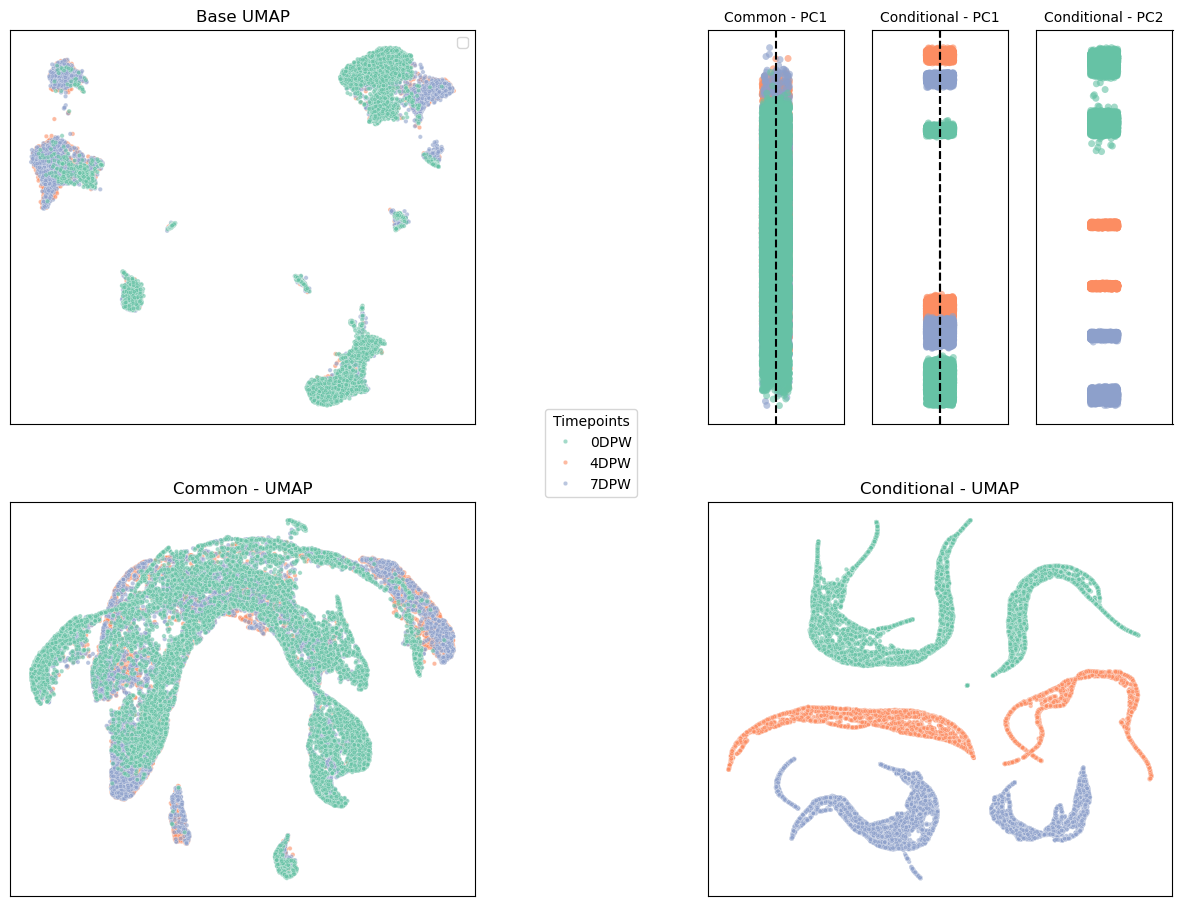

In [12]:
plot_fig(df, hue="time")

## Base & Latents per Condition - Age

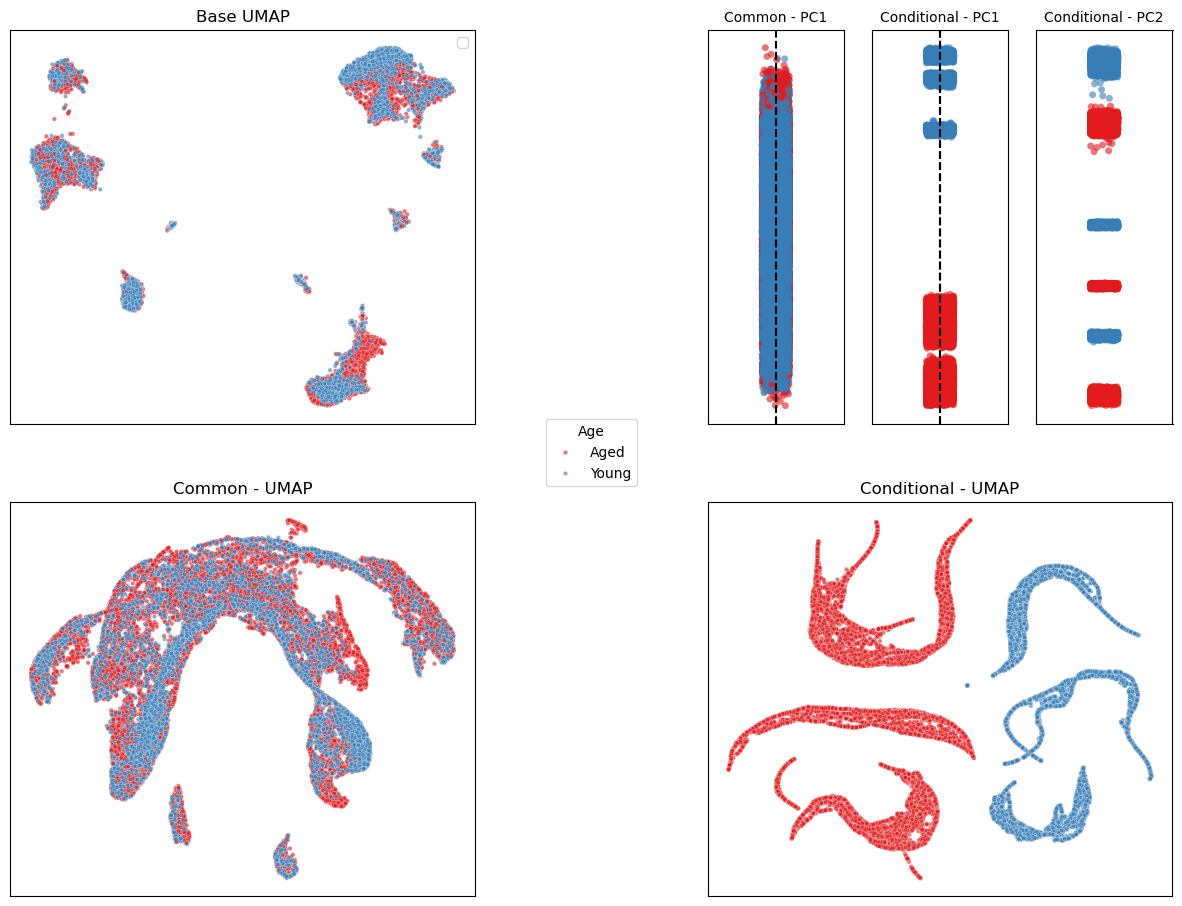

In [13]:
plot_fig(df, hue="age")

## Base & Latents per Attribute Combinations

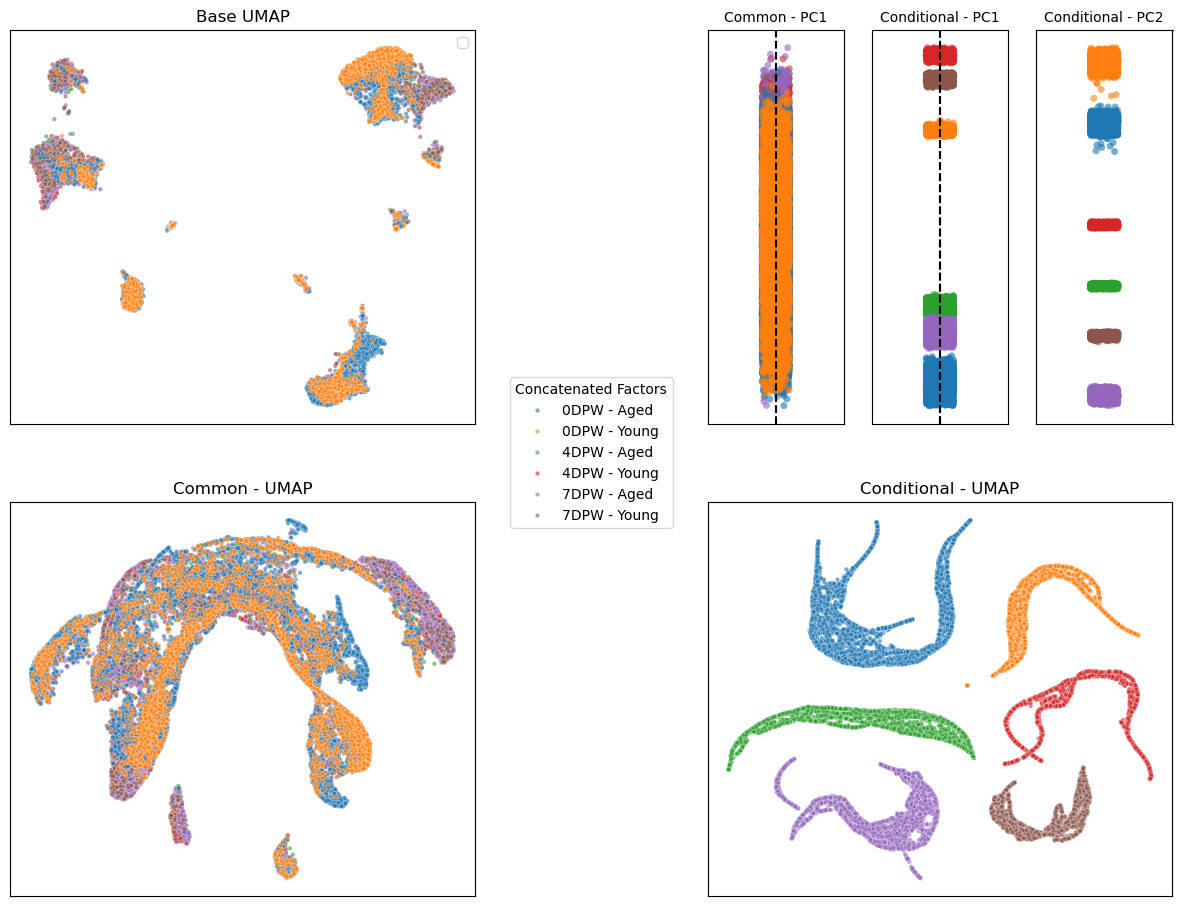

In [14]:
plot_fig(df, hue="factorized")